# Requirement *(Autoencoders for Image Denoising and Super-Resolution)*
* Xây dựng các mô hình Autoencoders cho hai tác vụ Denoising và Image Super-Resolution (2x upscaling). Chạy thực nghiệm và demo kết quả trên tập dữ liệu Tiny ImageNet (https://www.kaggle.com/c/tiny-imagenet/overview).
* Cần cho thấy kết quả huấn luyện mô hình, demo mô hình sau khi huấn luyên cho cả 2 tác vụ Denoising và Super-Resolution (2x upscaling).
* Kiến trúc Autoencoder có thể tham khảo trong tài liệu bài giảng tương ứng hoặc trong các nguồn khác. Kiến trúc Autoencoder cần được thay đổi cho phù hợp với mỗi dataset và tác vụ cụ thể.

## 1. Image Denoising <a class="anchor" id="image_denoising"></a>

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras import regularizers
import tensorflow as tf

In [2]:
# download TinyImageNet
!wget 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
!unzip -qq '/content/tiny-imagenet-200.zip'

--2024-04-08 14:27:07--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-04-08 14:27:07--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.9MB/s    in 12s     

2024-04-08 14:27:19 (20.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
from keras import backend as K
import time
import cv2
import numpy as np


def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('/content/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_data(id_dict, split):

    print('starting loading data')
    data = []
    t = time.time()
    if split == 'train':
      total_im = 25000
      for key, value in id_dict.items():
          data += [cv2.imread('/content/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
          if len(data) > total_im:
            break
    else:
      total_im = 2500
      for line in open('/content/tiny-imagenet-200/val/val_annotations.txt'):
          img_name, class_id = line.split('\t')[:2]
          data.append(cv2.imread('/content/tiny-imagenet-200/val/images/{}'.format(img_name)))
          if len(data) > total_im:
            break
    print('finished loading data, in {} seconds'.format(time.time() - t))
    data = np.array(data).astype('float32')
    data /= 255.
    return data

train_clean = get_data(get_id_dictionary(), 'train')
test_clean = get_data(get_id_dictionary(), 'test')
print("train_clean Shape: ",train_clean.shape)
print("test_clean Shape: ",test_clean.shape)

starting loading data
finished loading data, in 2.7354681491851807 seconds
starting loading data
finished loading data, in 0.26160645484924316 seconds
train_clean Shape:  (25200, 64, 64, 3)
test_clean Shape:  (2501, 64, 64, 3)


In [4]:
def add_noise_and_clip_data(data):
    noise = np.random.normal(loc = 0.0, scale = 0.3, size = data.shape)
    data = data + noise * 0.3
    data = np.clip(data, 0., 1.)
    return data

train_noisy = add_noise_and_clip_data(train_clean)
test_noisy = add_noise_and_clip_data(test_clean)

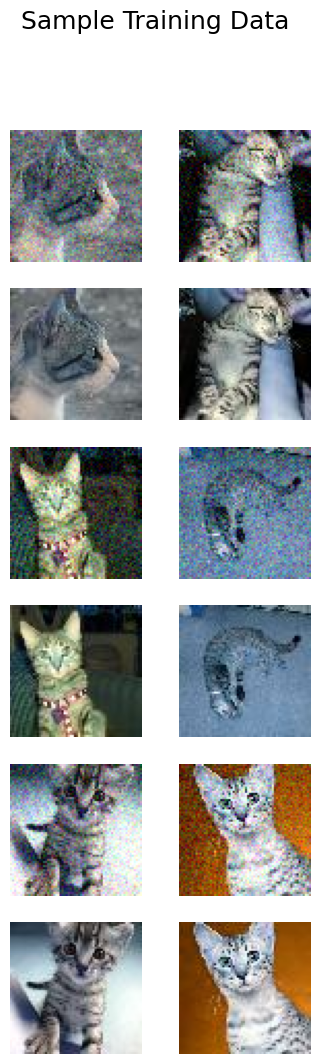

In [5]:
rows = 3 # defining no. of rows in figure
cols = 2 # defining no. of colums in figure

f = plt.figure(figsize = (2 * cols, 2 * rows * 2)) # defining a figure

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(train_noisy[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i + 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(train_clean[i * cols + j])
        plt.axis("off")

f.suptitle("Sample Training Data", fontsize = 18)
plt.savefig("TinyImagenet-train.png")

plt.show()

In [6]:
def conv_block(x, filters, kernel_size, strides = 2):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same',
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        padding = 'same',
                        activation = 'relu',
                        kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

In [7]:
def autoencoder():
    inputs = Input(shape = (64, 64, 3), name = 'inputs')
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3)
    conv_block6 = conv_block(conv_block5, 512, 3, 1)

    deconv_block1 = deconv_block(conv_block6, 512, 3)
    merge1 = Concatenate()([deconv_block1, conv_block4])
    deconv_block2 = deconv_block(merge1, 256, 3)
    merge2 = Concatenate()([deconv_block2, conv_block3])
    deconv_block3 = deconv_block(merge2, 128, 3)
    merge3 = Concatenate()([deconv_block3, conv_block2])
    deconv_block4 = deconv_block(merge3, 64, 3)
    merge4 = Concatenate()([deconv_block4, conv_block1])
    deconv_block5 = deconv_block(merge4, 32, 3)

    final_deconv = Conv2DTranspose(filters = 3, kernel_size = 3, padding = 'same')(deconv_block5)
    outputs = Activation('sigmoid', name = 'output')(final_deconv)
    return Model(inputs, outputs, name = 'autoencoder')

In [8]:
denoising_model = autoencoder()

def scheduler(epoch):
    if epoch < 20:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (20 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('denoising_model.weights.h5', verbose = 1, save_best_only = True, save_weights_only = True)

denoising_model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
denoising_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['inputs[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['batch_normalizatio

In [9]:
# Training
denoising_training_history = denoising_model.fit(train_noisy,
                                                 train_clean,
                                                 validation_data = (test_noisy, test_clean),
                                                 epochs = 20,
                                                 batch_size = 128,
                                                 shuffle = True,
                                                 callbacks = [checkpoint, callbacks, lr])

Epoch 1/20
197/197 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.4965
Epoch 1: val_loss improved from inf to 0.40981, saving model to denoising_model.weights.h5
197/197 [==============================] - 46s 134ms/step - loss: 1.0320 - accuracy: 0.4965 - val_loss: 0.4098 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 2/20
197/197 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.6442
Epoch 2: val_loss improved from 0.40981 to 0.10674, saving model to denoising_model.weights.h5
197/197 [==============================] - 19s 96ms/step - loss: 0.1882 - accuracy: 0.6442 - val_loss: 0.1067 - val_accuracy: 0.5907 - lr: 1.0000e-04
Epoch 3/20
197/197 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.7020
Epoch 3: val_loss improved from 0.10674 to 0.04089, saving model to denoising_model.weights.h5
197/197 [==============================] - 19s 96ms/step - loss: 0.0579 - accuracy: 0.7020 - val_loss: 0.0409 - val_accuracy: 0.66

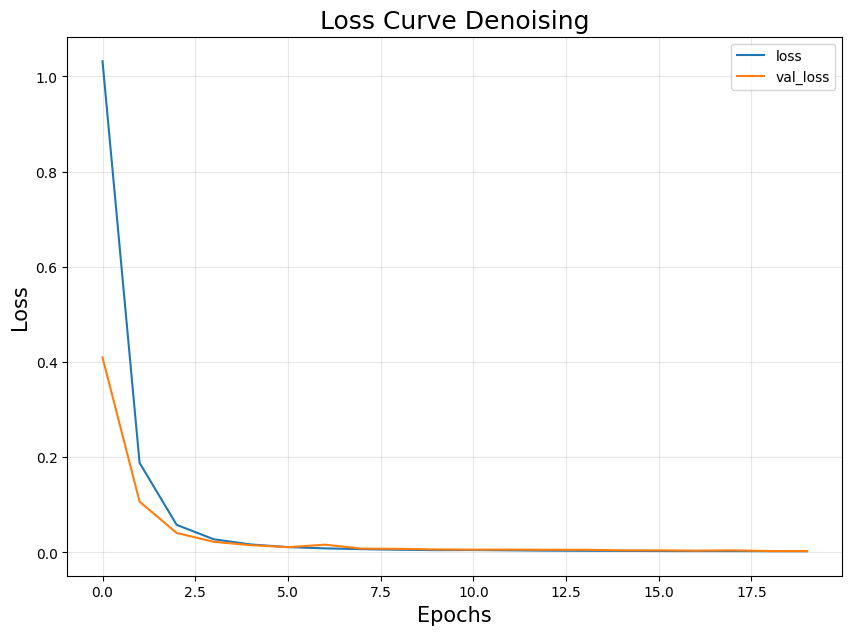

In [10]:
 # Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(denoising_training_history.epoch, denoising_training_history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(denoising_training_history.epoch, denoising_training_history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve Denoising",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
# plt.axis([0, 10, 0, 1])
plt.savefig("Loss_curve_denoising_tinyimagenet.png")
plt.show()

In [11]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, test_noisy.shape[0]-48)

tinyimagenet_test_images = test_noisy[rand:rand+num_imgs] # slicing
tinyimagenet_test_predicted = denoising_model.predict(tinyimagenet_test_images) # predict

2/2 [==============================] - 2s 940ms/step


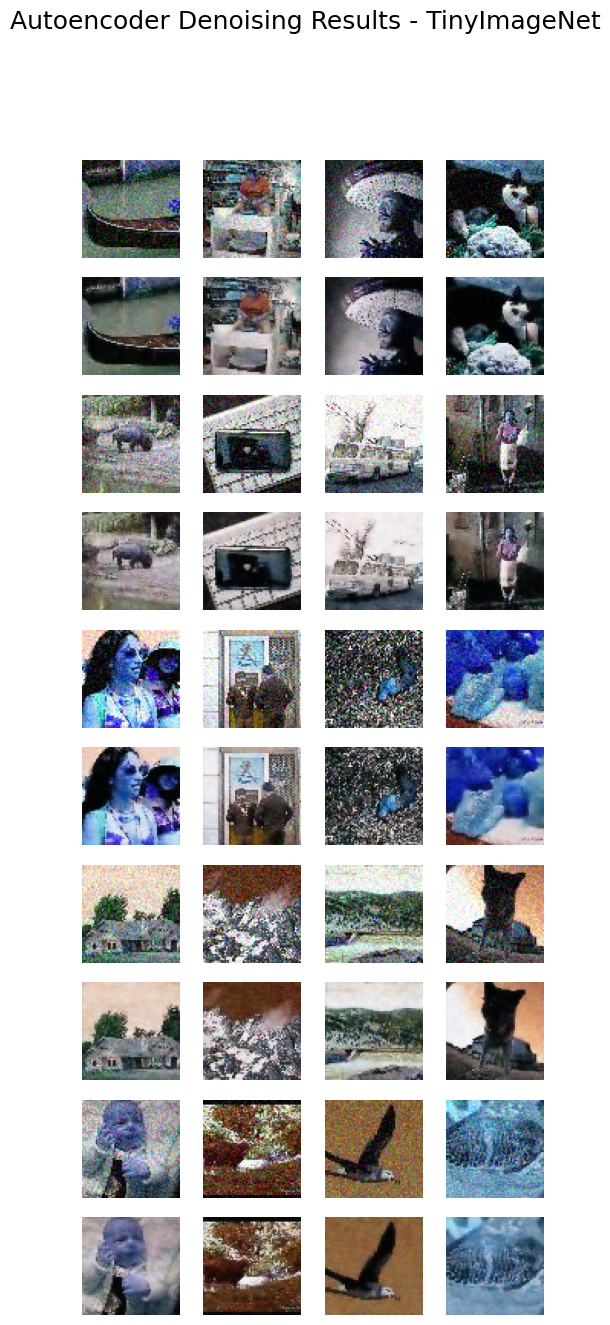

In [12]:
rows = 5 # defining no. of rows in figure
cols = 4 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure
f.tight_layout()
for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(tinyimagenet_test_images[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(tinyimagenet_test_predicted[i * cols + j])
        plt.axis("off")

f.suptitle("Autoencoder Denoising Results - TinyImageNet",fontsize=18)
plt.savefig("denoising_test_results_tinyimagenet.png")

plt.show()

## 2. Super-Resolution <a class="anchor" id="super-resolution"></a>

In [13]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        ax[i].imshow(z.reshape(64,64) if z.size==64*64 else z.reshape(32,32) if z.size==32*32 else z)
    plt.show()

In [14]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mse
from keras.layers import AveragePooling2D
import numpy as np

In [15]:
x_train = train_clean
x_test = test_clean

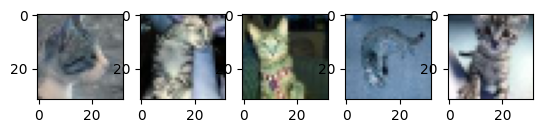

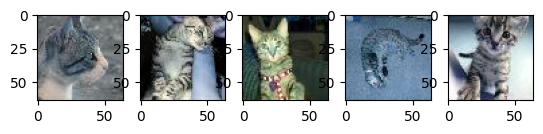

In [16]:
# # Normalize pixel values to be between 0 and 1
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

x_train_lr = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x_test).numpy()
plotn(5, x_train_lr)
plotn(5, x_train)

In [17]:
# Define input shape
inputs = Input(shape=(32, 32, 3), name='inputs')

# Encoder
conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv2)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv3)
conv4 = BatchNormalization()(conv4)

# Decoder
deconv1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv4)
deconv1 = BatchNormalization()(deconv1)
deconv2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(deconv1)
deconv2 = BatchNormalization()(deconv2)
deconv3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(deconv2)
deconv3 = BatchNormalization()(deconv3)
deconv4 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(deconv3)
deconv4 = BatchNormalization()(deconv4)
# deconv5 = Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(deconv4)
# deconv5 = BatchNormalization()(deconv5)

# Output
outputs = Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid')(deconv4)

# Create model
autoencoder = Model(inputs, outputs, name='autoencoder')

In [18]:
super_resolution_model = autoencoder

def scheduler(epoch):
    if epoch < 20:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (20 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('super-resolution_model.weights.h5', verbose = 1, save_best_only = True, save_weights_only = True)

super_resolution_model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
super_resolution_model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_11 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_12 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         

In [19]:
# Training
super_resolution_training_history = super_resolution_model.fit(x_train_lr,
                                                               x_train,
                                                               validation_data = (x_test_lr, x_test),
                                                               epochs = 20,
                                                               batch_size = 128,
                                                               shuffle = True,
                                                               callbacks = [checkpoint, callbacks, lr])

Epoch 1/20
197/197 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.4788
Epoch 1: val_loss improved from inf to 0.06701, saving model to super-resolution_model.weights.h5
197/197 [==============================] - 20s 67ms/step - loss: 0.0392 - accuracy: 0.4788 - val_loss: 0.0670 - val_accuracy: 0.5147 - lr: 1.0000e-04
Epoch 2/20
196/197 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.6239
Epoch 2: val_loss improved from 0.06701 to 0.02566, saving model to super-resolution_model.weights.h5
197/197 [==============================] - 11s 56ms/step - loss: 0.0189 - accuracy: 0.6240 - val_loss: 0.0257 - val_accuracy: 0.5819 - lr: 1.0000e-04
Epoch 3/20
196/197 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.6544
Epoch 3: val_loss improved from 0.02566 to 0.01567, saving model to super-resolution_model.weights.h5
197/197 [==============================] - 11s 57ms/step - loss: 0.0164 - accuracy: 0.6545 - val_loss: 0.0157 

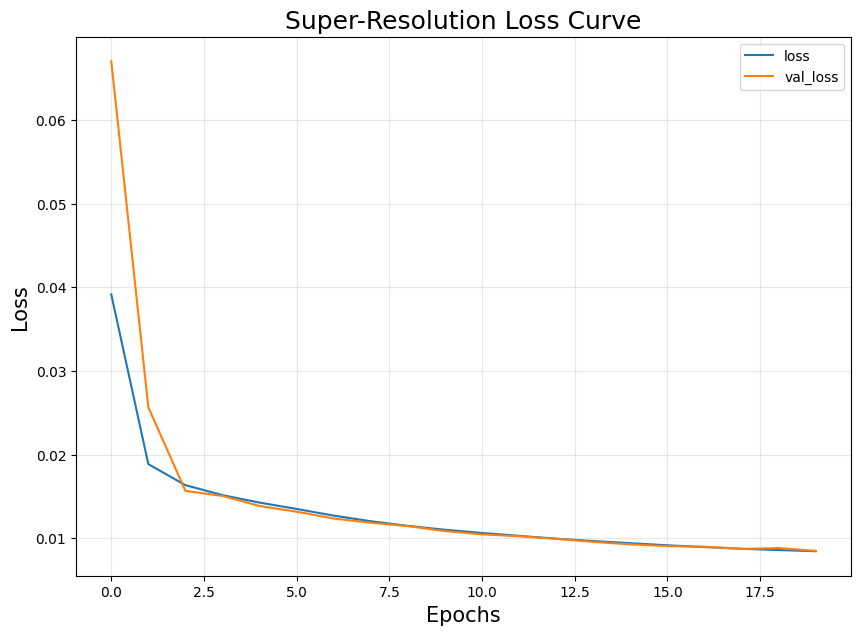

In [20]:
 # Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(super_resolution_training_history.epoch, super_resolution_training_history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(super_resolution_training_history.epoch, super_resolution_training_history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Super-Resolution Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_super-resolution_tinyimagenet.png")
plt.show()

In [21]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, x_test_lr.shape[0]-48)

tinyimagenet_test_images = x_test_lr[rand:rand+num_imgs] # slicing
tinyimagenet_test_predicted = super_resolution_model.predict(tinyimagenet_test_images) # predict

2/2 [==============================] - 1s 256ms/step


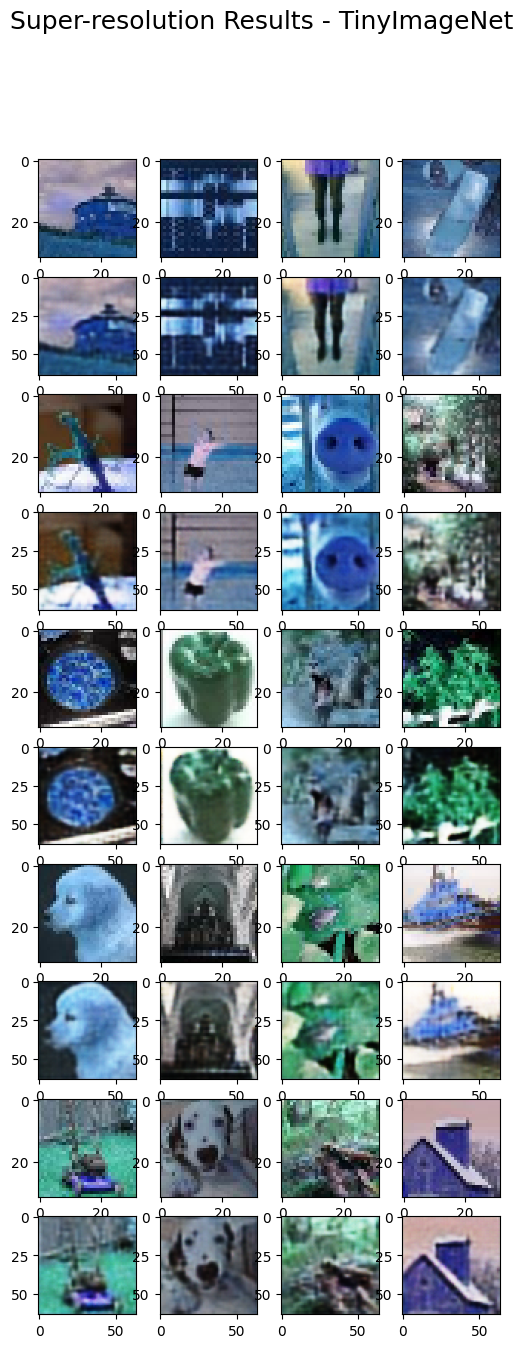

In [22]:
rows = 5 # defining no. of rows in figure
cols = 4 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure
f.tight_layout()
for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(tinyimagenet_test_images[i * cols + j])
        plt.axis("on")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(tinyimagenet_test_predicted[i * cols + j])
        plt.axis("on")

f.suptitle("Super-resolution Results - TinyImageNet",fontsize=18)
plt.savefig("super-resolution_test_results_tinyimagenet.png")

plt.show()